In [1]:

import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("book_data.csv")
df_temp = pd.read_csv("book_data.csv")

In [3]:
X_desc = df['book_desc']
y_genre = df['genres']

In [4]:
df['genres']

0        Young Adult|Fiction|Science Fiction|Dystopia|F...
1                              Fantasy|Young Adult|Fiction
2        Classics|Fiction|Historical|Historical Fiction...
3                                 Classics|Fiction|Romance
4        Young Adult|Fantasy|Romance|Paranormal|Vampire...
                               ...                        
54296    Sports|Baseball|Sports and Games|Sports|Nonfic...
54297                   Nonfiction|Sports and Games|Sports
54298                            Sports|Baseball|Abandoned
54299    Nonfiction|Autobiography|Memoir|Biography|Psyc...
54300    Criticism|Literary Criticism|Philosophy|Theory...
Name: genres, Length: 54301, dtype: object

In [5]:
#Convert Genres which are strings to dictionaries in order to obtain values
for i in range(0,54301):
    WordList = ''
    counter = 1
    Word_Dic = {}
    df['genres'][i] = str(df['genres'][i])+'|'
    for k in df['genres'][i]:
        if(k != '|'):
            WordList = WordList+k
        if(k=='|'):
            Word_Dic[counter] = WordList
            counter = counter+1
            WordList = ''
    df['genres'][i] = Word_Dic
    
for i in range(0,54301):
    result = {}
    for key,value in df['genres'][i].items():
        if value not in result.values():
            result[key] = value
    df['genres'][i] = result
        

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
#now that dictionary I can get idividual values of labels
df['genres'][4].items()

dict_items([(1, 'Young Adult'), (2, 'Fantasy'), (3, 'Romance'), (4, 'Paranormal'), (5, 'Vampires'), (6, 'Fiction')])

In [7]:
# an empty list
genres = [] 

# extract genres
for i in df['genres']: 
    genres.append(list(i.values())) 

# add to genres dataframe  
df['genre_new'] = genres

In [8]:
df_new = df[~(df['genre_new'].str.len() == 0)]

In [9]:
#get number of unique genres
all_genres = sum(genres,[])
len(set(all_genres))

867

In [10]:
#count all genres
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

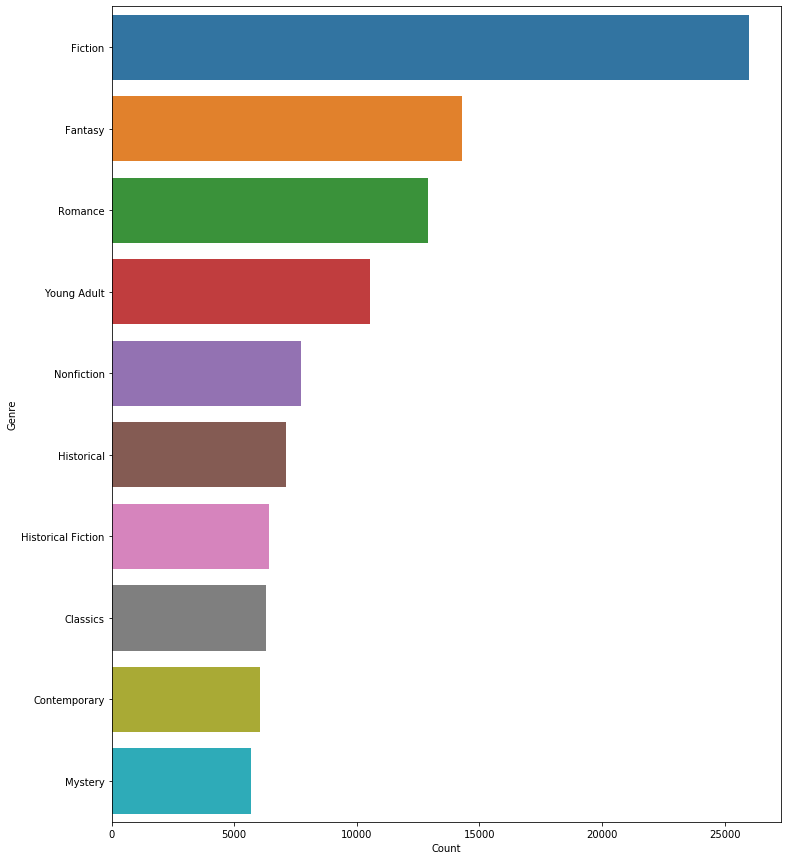

In [11]:
#plot genres to show 50 most frequent genres
g = all_genres_df.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [12]:
# function for text cleaning 
#will remove noisy words from book descriptions
def clean_text(text):
    text = str(text)
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [13]:
#apply clean_text function
df_new['clean_book_desc'] = df_new['book_desc'].apply(lambda x: clean_text(x))

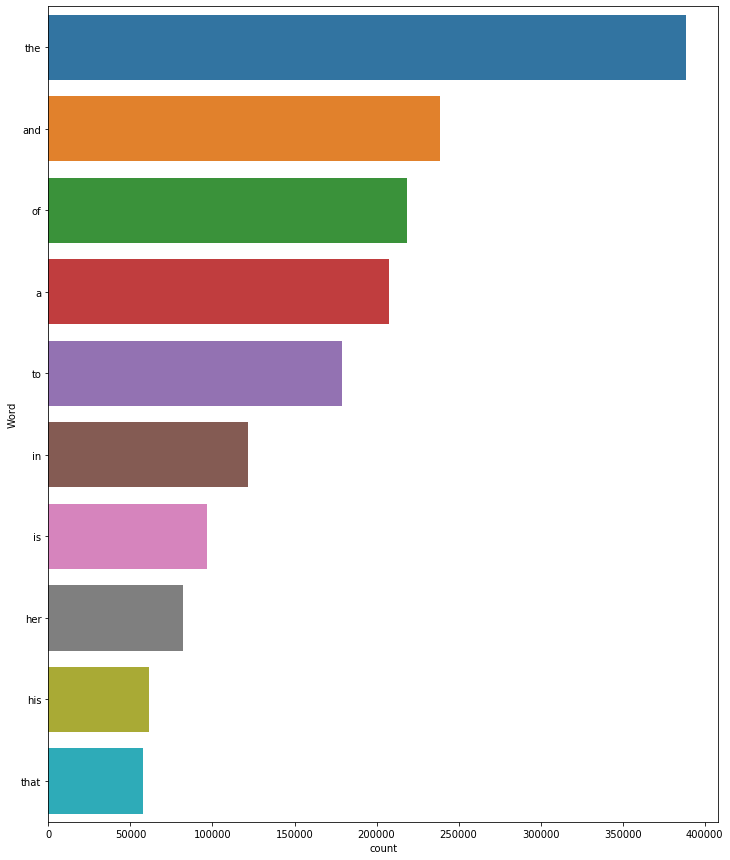

In [14]:
#Plot most frequent words in book description
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  # print 100 most frequent words 
freq_words(df_new['clean_book_desc'], 10)

In [15]:
#nltk.download('stopwords')

In [16]:
#stop words 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df_new['clean_book_desc']= df_new['clean_book_desc'].apply(lambda x: remove_stopwords(x))

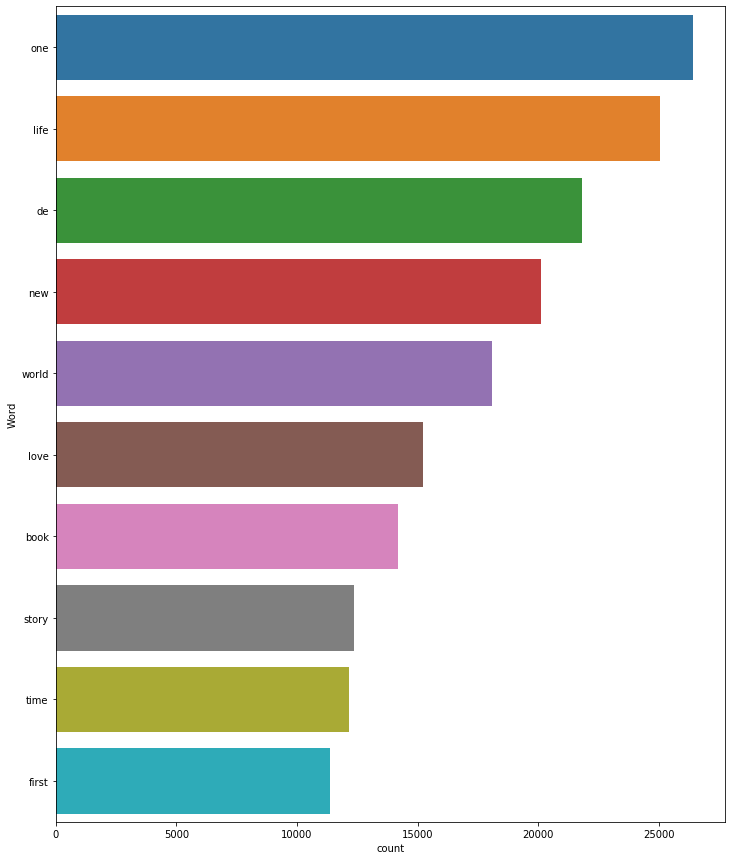

In [17]:
freq_words(df_new['clean_book_desc'], 10)


In [18]:
#convert labels that are dictionaries with multiple values into multilabel columns using mulilabelbinarizer, similar
#to onehotencoding
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(df_new['genre_new'])


In [19]:
import nltk
# nltk.download('punkt')
import string  
from nltk.tokenize import word_tokenize

#going to use word2vec for word embedding, need to tokenize words first to pass them to embedding layer of NN
#essentially converts text to vector format
word_lines = list()
lines = df_new['clean_book_desc'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # dont want token without alphabetic letters
    words = [word for word in stripped if word.isalpha()]
    word_lines.append(words)

In [20]:
#!pip install -U gensim
import gensim 

#now extract features using word2 vec
EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=word_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

unable to import 'smart_open.gcs', disabling that module


Vocabulary size: 221319


In [21]:
# save model 
filename = 'books_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [22]:
#test word embedding model, here I test which words are similar to happy
model.wv.most_similar('happy')

[('enjoying', 0.8387259840965271),
 ('lucky', 0.8319791555404663),
 ('comfortable', 0.8085856437683105),
 ('sure', 0.8006858825683594),
 ('loving', 0.7978606224060059),
 ('missed', 0.7977293729782104),
 ('expect', 0.7953713536262512),
 ('crazy', 0.7934300303459167),
 ('nice', 0.7930598855018616),
 ('talk', 0.7904881238937378)]

In [23]:
import os

#load saved model
embeddings_index = {}
f = open(os.path.join('', 'books_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [24]:
#here to actually represent our text data in our network we need to convert each word to a unique integer
#This step is crucial in order to be able to properly word embedd
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
max_length=200
# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(word_lines)
sequences = tokenizer_obj.texts_to_sequences(word_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

desc_pad = pad_sequences(sequences, maxlen=max_length)
genres_pad =  df_new['genre_new'].values
print('Shape of word tensor:', desc_pad.shape)
print('Shape of genre tensor:', genres_pad.shape)


Found 221319 unique tokens.
Shape of word tensor: (54301, 200)
Shape of genre tensor: (54301,)


In [25]:
len(word_index)

221319

In [26]:
#will need total number of rows we are 
total_book_desc = df_new['clean_book_desc']
max_length = 200 # try other options like mean of sentence lengths

In [56]:
#split data
xtrain, xval, ytrain, yval = train_test_split(desc_pad, y, test_size=0.2, random_state=42)

In [57]:
#embedding dimension for our word embedding model
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [58]:
print(num_words)

221320


In [59]:
#define precision, recall , and f1 to use as a metric for our NN
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.layers import Dropout
from sklearn.metrics import hamming_loss
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import f1_score

model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)   
model.add(LSTM(128, return_sequences=True))  
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(867, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy',recall_m,precision_m,f1_m])
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 100)          22132000  
_________________________________________________________________
lstm_23 (LSTM)               (None, 200, 128)          117248    
_________________________________________________________________
dropout_23 (Dropout)         (None, 200, 128)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 867)               56355     
Total params: 22,355,011
Trainable params: 223,011
Non-trainable params: 22,132,000
___________________________________

In [32]:
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=10, shuffle=True)

# # K-fold Cross Validation model evaluation
# fold_no = 1
# for train, test in kfold.split(desc_pad, y):

#   # Define the model architecture
#     model = Sequential()
#     embedding_layer = Embedding(num_words,
#                             EMBEDDING_DIM,
#                             embeddings_initializer=Constant(embedding_matrix),
#                             input_length=max_length,
#                             trainable=False)
#     model.add(embedding_layer)   
#     model.add(LSTM(128, return_sequences=True))  
#     model.add(Dropout(0.5))
#     model.add(LSTM(64))
#     model.add(Dropout(0.5))
#     # Adding a dense output layer with sigmoid activation
#     model.add(Dense(867, activation='sigmoid'))
#     model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])


#   # Generate a print
#     print('------------------------------------------------------------------------')
#     print(f'Training for fold {fold_no} ...')

#   # Fit data to model
#     history = model.fit(desc_pad[train], y[train],
#                     class_weight='balanced',
#                     epochs=5,
#                     batch_size=32,
#                     validation_split=0.2,
#                     callbacks=[],verbose=2)  
#      predictions=model.predict(desc_pad[test])
#             thresh = .12
#             pred=predictions.copy()
#             pred[pred>=thresh]=1
#             pred[pred<thresh]=0
  
#             precision = precision_score(yval, pred, average='micro')
#             recall = recall_score(yval, pred, average='micro')
#             f1 = f1_score(yval, pred, average='micro')

#     print("Micro-average quality numbers")
#     print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
#   # Generate generalization metrics
#     scores = model.evaluate(desc_pad[test], y[test], verbose=2)
# #     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
# #     acc_per_fold.append(scores[1] * 100)
# #     loss_per_fold.append(scores[0])

#   # Increase fold number
#     fold_no = fold_no + 1

# # == Provide average scores ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
    

In [61]:
#train the model
#use class weight set to balanced due to bias towards 0's in our binary labels
history = model.fit(xtrain, ytrain,
                    class_weight='balanced',
                    epochs=5,
                    batch_size=32,
                    validation_data=(xval, yval),
                    callbacks=[],
                    verbose=2)      

Train on 43440 samples, validate on 10861 samples
Epoch 1/5
 - 1203s - loss: 0.0368 - accuracy: 0.9917 - recall_m: 0.0332 - precision_m: 0.4466 - f1_m: 0.0542 - val_loss: 0.0226 - val_accuracy: 0.9944 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/5
 - 1214s - loss: 0.0231 - accuracy: 0.9944 - recall_m: 0.0268 - precision_m: 0.4143 - f1_m: 0.0485 - val_loss: 0.0225 - val_accuracy: 0.9944 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/5
 - 582s - loss: 0.0231 - accuracy: 0.9944 - recall_m: 0.0261 - precision_m: 0.4003 - f1_m: 0.0472 - val_loss: 0.0225 - val_accuracy: 0.9944 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/5
 - 586s - loss: 0.0230 - accuracy: 0.9944 - recall_m: 0.0249 - precision_m: 0.3921 - f1_m: 0.0452 - val_loss: 0.0226 - val_accuracy: 0.9944 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 5/5
 - 585s - loss: 0.

In [62]:
#Evaluate our model
print('Testing...')
(loss, 
accuracy,recall, precision,f1) = model.evaluate(xval, yval, verbose=2)
#print('Test score:', score)
# print('Test accuracy:', acc)

# print("Accuracy: {0:.2%}".format(acc))

Testing...


In [66]:
print("Loss: {:.4f}, Accuracy: {:.4f}, recall: {:.4f}, precision: {:.4f}, F1: {:.4f}".format(loss,accuracy,recall,precision,f1))

Loss: 0.0226, Accuracy: 0.9944, recall: 0.0000, precision: 0.0000, F1: 0.0000


In [67]:
#testing values
#chose label 4 because it has many book genres
df['genres'][4].values()

dict_values(['Young Adult', 'Fantasy', 'Romance', 'Paranormal', 'Vampires', 'Fiction'])

In [72]:
#here ill evaluate my model based on prediction
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss
#different thresholds for what values we assign as 0 or 1 in labels
thresholds=[0.1,0.12,0.13,0.14,.15,.16,.17,.18,.19,.2]
predictions=model.predict(xval)
for val in thresholds:

    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
    
   #different performance metrics namely, precision, recall,f1,and hamming loss
    precision = precision_score(yval, pred, average='micro')
    recall = recall_score(yval, pred, average='micro')
    f1 = f1_score(yval, pred, average='micro')
    ham = hamming_loss(yval,pred)
    print("Threshhold of: {:.4f} ".format(val))
    print("Predicted Genres Based on threshold:")
    print(multilabel_binarizer.inverse_transform(pred)[4])
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Hamming-measure: {:.4f}".format(precision, recall, f1,ham))


Threshhold of: 0.1000 
Predicted Genres Based in threshold:
('Classics', 'Contemporary', 'Fantasy', 'Fiction', 'Historical', 'Historical Fiction', 'Nonfiction', 'Paranormal', 'Romance', 'Science Fiction', 'Young Adult')
Micro-average quality numbers
Precision: 0.1799, Recall: 0.4095, F1-measure: 0.2500, Hamming-measure: 0.0137
Threshhold of: 0.1200 
Predicted Genres Based in threshold:
('Fantasy', 'Fiction', 'Historical', 'Nonfiction', 'Romance', 'Young Adult')
Micro-average quality numbers
Precision: 0.2402, Recall: 0.2982, F1-measure: 0.2661, Hamming-measure: 0.0092
Threshhold of: 0.1300 
Predicted Genres Based in threshold:
('Fantasy', 'Fiction', 'Historical', 'Nonfiction', 'Romance', 'Young Adult')
Micro-average quality numbers
Precision: 0.2402, Recall: 0.2982, F1-measure: 0.2661, Hamming-measure: 0.0092
Threshhold of: 0.1400 
Predicted Genres Based in threshold:
('Fantasy', 'Fiction', 'Nonfiction', 'Romance', 'Young Adult')
Micro-average quality numbers
Precision: 0.2625, Recall:

In [ ]:
# #Let us test some  samples
# # load the dataset but only keep the top n words, zero the rest

# test_sample_1 = "Winning will make you famous"
# test_sample_2 = "In this fearless and half-crazy story"
# test_sample_3 = "Maybe I like this movie."
# test_sample_4 = "Not to my taste, will skip and watch another movie"
# test_sample_5 = "if you like action, then this movie might be good for you."
# test_sample_6 = "Bad movie!"
# test_sample_7 = "Not a good movie!"
# test_sample_8 = "This movie really sucks! Can I get my money back please?"
# test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

# test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
# test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=100)

# #predict
# model.predict(x=test_samples_tokens_pad)

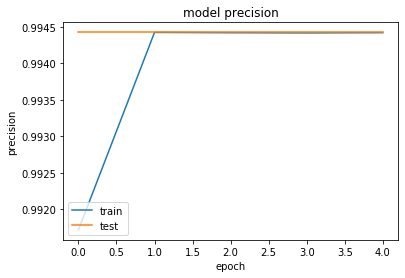

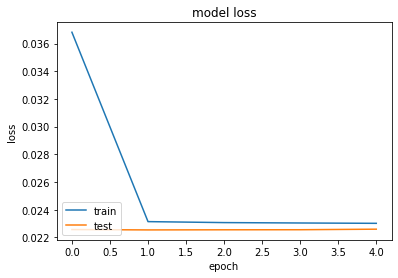

In [77]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()